#  Прогнозирование заказов такси

Компания такси собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Нужно построить модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

План:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders`.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Сезонная-декомпозиция" data-toc-modified-id="Сезонная-декомпозиция-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Сезонная декомпозиция</a></span></li><li><span><a href="#Скользящее-среднее" data-toc-modified-id="Скользящее-среднее-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Скользящее среднее</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Выводы</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Добавление-новых-признаков-и-разделение-данных" data-toc-modified-id="Добавление-новых-признаков-и-разделение-данных-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Добавление новых признаков и разделение данных</a></span></li><li><span><a href="#Выбор-модели-и-подбор-гиперпараметров" data-toc-modified-id="Выбор-модели-и-подбор-гиперпараметров-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Выбор модели и подбор гиперпараметров</a></span><ul class="toc-item"><li><span><a href="#Lasso()" data-toc-modified-id="Lasso()-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Lasso()</a></span></li><li><span><a href="#RandomForestRegressor()" data-toc-modified-id="RandomForestRegressor()-3.2.2"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>RandomForestRegressor()</a></span></li><li><span><a href="#CatBoostRegressor()" data-toc-modified-id="CatBoostRegressor()-3.2.3"><span class="toc-item-num">3.2.3&nbsp;&nbsp;</span>CatBoostRegressor()</a></span></li></ul></li><li><span><a href="#Лучшая-модель-и-значимость-признаков" data-toc-modified-id="Лучшая-модель-и-значимость-признаков-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Лучшая модель и значимость признаков</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Итоговые-выводы" data-toc-modified-id="Итоговые-выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Итоговые выводы</a></span></li></ul></div>

In [1]:
!pip install catboost matplotlib==3.5.3 numpy==1.22 seaborn==0.11.1 -q
!pip install shap -q
!pip install -U scikit-learn -q

In [2]:
# загружаем библиотеки
import catboost
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
import warnings

from statsmodels.graphics import tsaplots
from statsmodels.tsa.seasonal import seasonal_decompose

# загружаем классы для подготовки данных
from sklearn import set_config
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# загружаем библиотеки для МО
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate, GridSearchCV, TimeSeriesSplit, train_test_split

In [3]:
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
set_config(display="diagram")
# зафиксируем RANDOM_STATE
RANDOM_STATE = 42
# зафиксируем TEST_SIZE
TEST_SIZE = 0.1

In [6]:
def data_import(file_name: str) -> pd.DataFrame:

    local_pth = '/datasets/' + file_name
    server_pth = 'https://example.ru/' + file_name

    try:
        data = pd.read_csv(local_pth, parse_dates=['datetime'], index_col=['datetime'])
    except:
        data = pd.read_csv(server_pth, parse_dates=['datetime'], index_col=['datetime'])
    
    return data

## Подготовка

In [7]:
# загрузим файл 
df_taxi = data_import('taxi.csv')
print(f'Монотонность данных: {df_taxi.index.is_monotonic}')

Монотонность данных: True


In [8]:
# ресемплируем данные по 1 часу
df_taxi = df_taxi.resample('1H').sum()
# выведем первые строки
display(df_taxi.head())
print()
# выведем информацию 
df_taxi.info()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


## Анализ

In [9]:
plt.show()
plt.rcParams['figure.titlesize'] = 15
plt.rcParams['font.size'] = 13
plt.rcParams['figure.figsize'] = (10, 7.5)

Построим график данных по часам, по дням, по неделям и по месяцам.

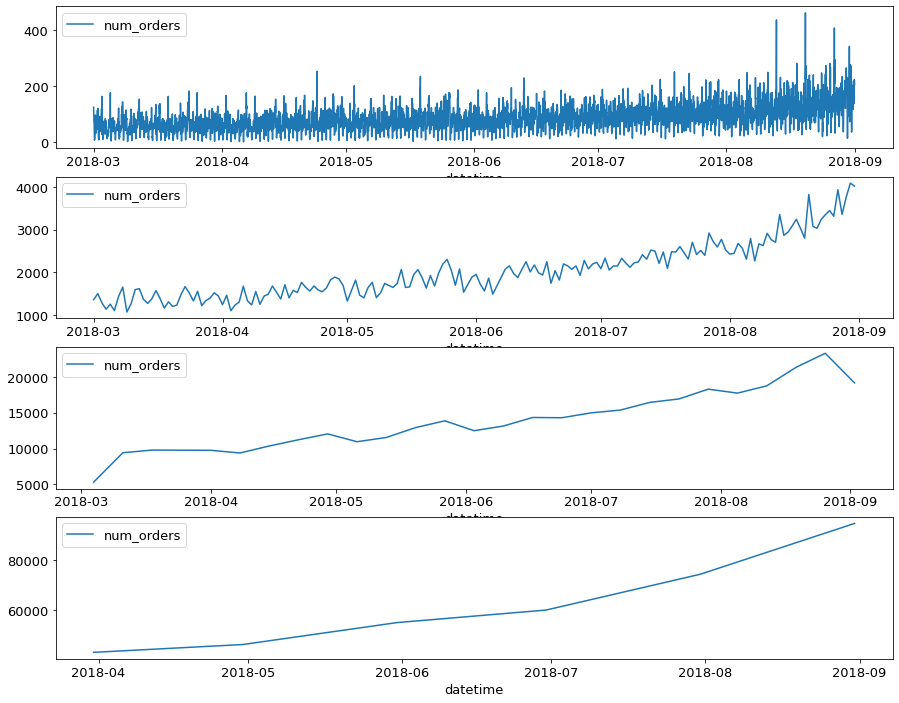

In [10]:
plt.figure(figsize=(15, 12))
plt.subplot(411)
sns.lineplot(data=df_taxi)
plt.subplot(412)
sns.lineplot(data=df_taxi.resample('1D').sum())
plt.subplot(413)
sns.lineplot(data=df_taxi.resample('1W').sum())
plt.subplot(414)
sns.lineplot(data=df_taxi.resample('1M').sum());

С увеличением периода ресемплирования, все очевиднее тренд на увеличение кол-ва заказов такси. На последнем графике лучше всего заметно, что тренд растет не линейно, а с ускорением.

Изучим подробнее тренды и сезонности данных.

### Сезонная декомпозиция

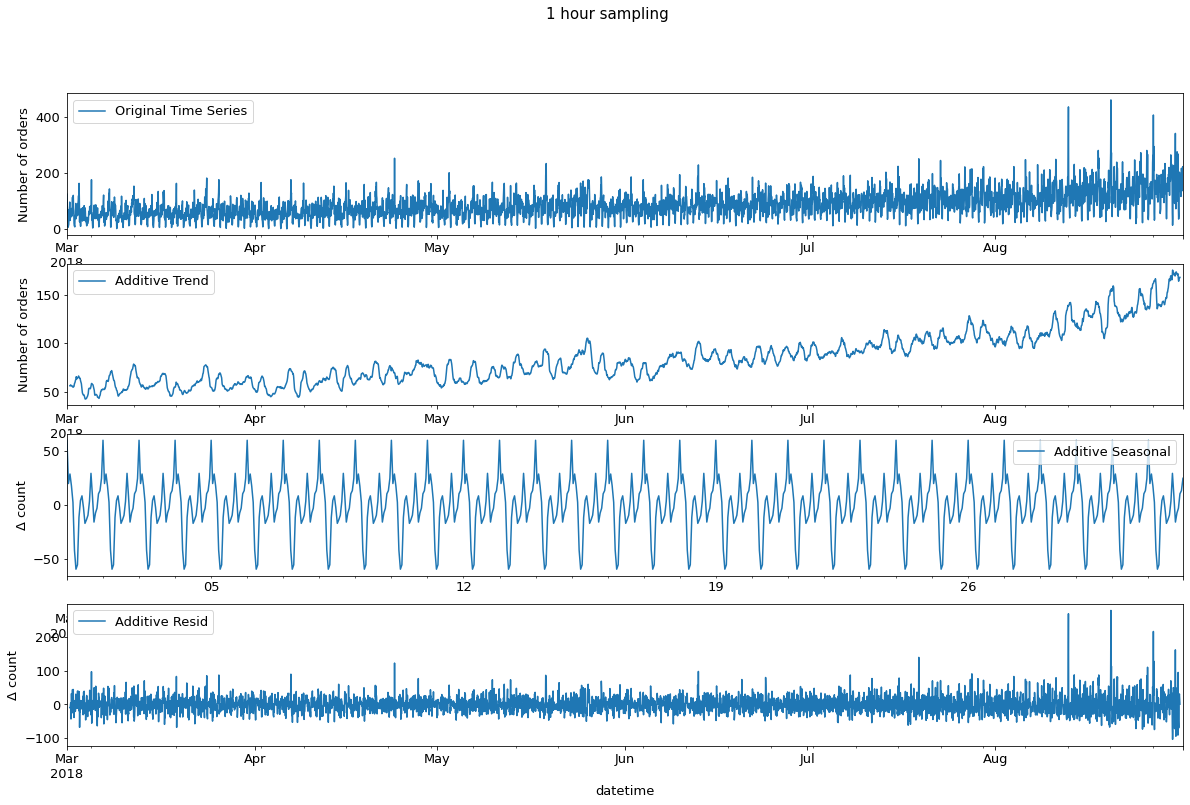

In [11]:
ts = df_taxi.num_orders
result_add = seasonal_decompose(ts, model='additive')

fig, ax = plt.subplots(4, 1, figsize=(20, 12))
fig.suptitle('1 hour sampling')

result_add.observed.plot(label='Original Time Series', ax=ax[0] )
ax[0].set_ylabel('Number of orders')
ax[0].legend()

result_add.trend.plot(label='Additive Trend', ax=ax[1])
ax[1].set_ylabel('Number of orders')
ax[1].legend()

result_add.seasonal['2018-03'].plot(label='Additive Seasonal', ax=ax[2])
ax[2].set_ylabel('Δ count')
ax[2].legend()

result_add.resid.plot(label='Additive Resid', ax=ax[3])
ax[3].set_ylabel('Δ count')
ax[3].legend();

Ежедневно тренд в целом растет. Наблюдаются суточная сезонность (в одно и тоже время каждый день). По шуму можно сказать, что ближе к настоящему времени есть нельсколько выбросных значений, плотность шума чуть больше, но амплитуда в среднем такая же как на остальных данных.



Проверим сезонность ресемплировав данные по дню.

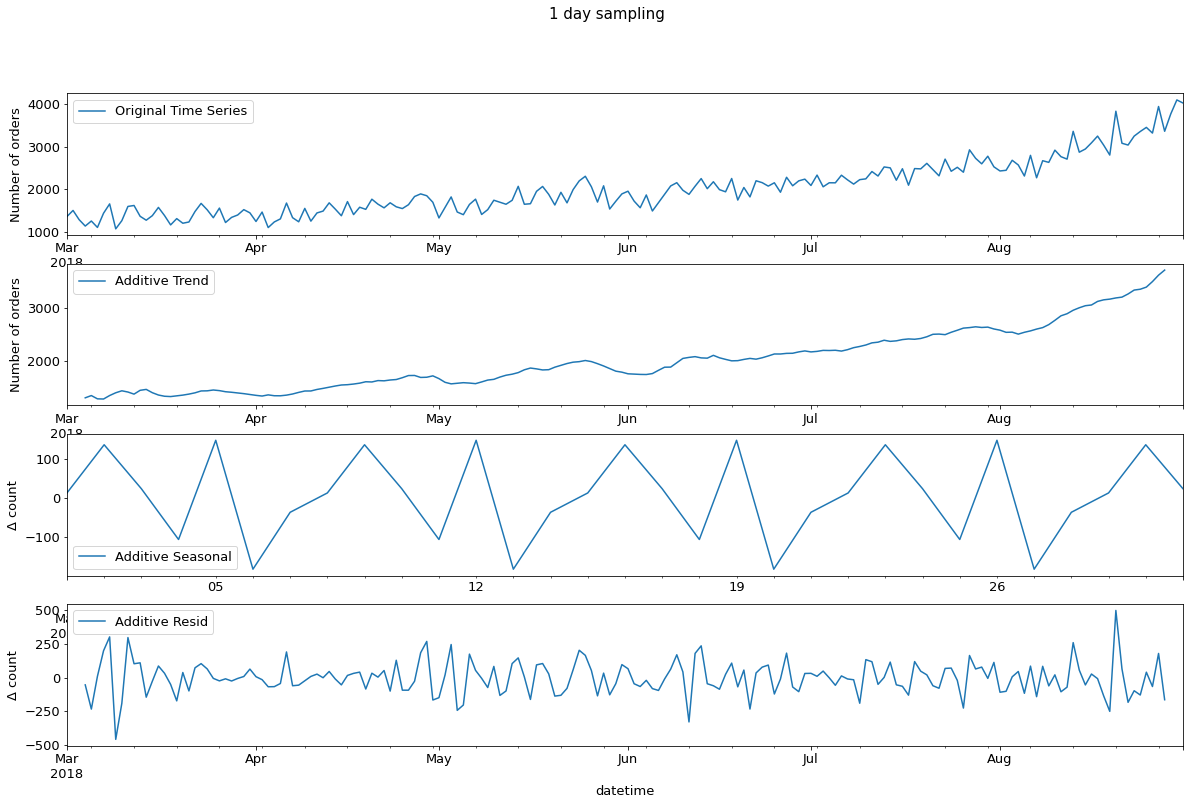

In [12]:
ts = df_taxi.num_orders.resample('1D').sum()
result_add = seasonal_decompose(ts, model='additive')


fig, ax = plt.subplots(4, 1, figsize=(20, 12))
fig.suptitle('1 day sampling')

result_add.observed.plot(label='Original Time Series', ax=ax[0])
ax[0].set_ylabel('Number of orders')
ax[0].legend()

result_add.trend.plot(label='Additive Trend', ax=ax[1])
ax[1].set_ylabel('Number of orders')
ax[1].legend()

result_add.seasonal['2018-03'].plot(label='Additive Seasonal', ax=ax[2])
ax[2].set_ylabel('Δ count')
ax[2].legend()

result_add.resid.plot(label='Additive Resid', ax=ax[3])
ax[3].set_ylabel('Δ count')
ax[3].legend();

Наблюдается тренд увеличения заказов и недельная сезонность (в один день каждую неделю). Шум в порядке нормы, аномальных выбросов не наблюдается.

### Скользящее среднее

In [13]:
ts = df_taxi.num_orders.resample('1D')

sma_window = 7  # 7-day moving average
sma = ts.sum().rolling(window=sma_window).mean()

ema_window = 30 # 30-day moving average
ema = ts.sum().ewm(span=ema_window, adjust=False).mean()

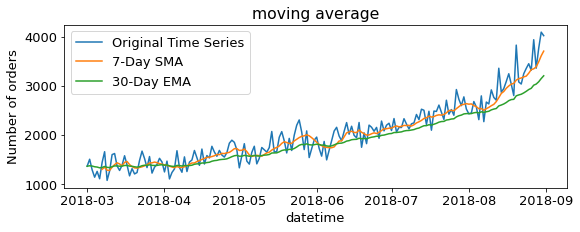

In [14]:
plt.figure(figsize=(9, 3))
plt.plot(ts.sum(), label='Original Time Series')
plt.plot(sma, label=f'{sma_window}-Day SMA')
plt.plot(ema, label=f'{ema_window}-Day EMA')
plt.title('moving average')
plt.xlabel('datetime')
plt.ylabel('Number of orders')
plt.legend();

### Выводы

1. Данные ресемплированы по часу, пропусков данных не наблюдается, данные хронологически верно расставлены.
1. В данных наблюдается нелинейный тренд увеличения кол-ва заказов.
2. Присутствует 2 сезооности: суточная, недельная.
4. Анализ шума ряда не показал значительных выбросов к концу графика.

## Обучение

### Добавление новых признаков и разделение данных

In [15]:
def make_features(df: pd.DataFrame, max_h_lag: int, max_d_lag: int, max_w_lag: int, rolling_mean_size: list) -> pd.DataFrame:
    '''
    Add new features to pd.DataFrame:
    
    Return new features:
    'hour',
    'day_of_week',
    (max_h_lag + 1) 'lags_h',
    (max_d_lag + 1) 'lags_d',
    (max_w_lag + 1) 'lags_w',
    'rolling_mean_24_h'
    'rolling_mean_168_h'
    'rolling_mean' with window = rolling_mean_size
    '''
    
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    
    for h in range(1, max_h_lag + 1):
        df['lag_{}_h'.format(h)] = df['num_orders'].shift(h)
    
    for d in range(1, max_d_lag + 1):
        df['lag_{}_d'.format(d)] = df['num_orders'].shift(d * 24)
        
    for w in range(1, max_w_lag + 1):
        df['lag_{}_w'.format(w)] = df['num_orders'].shift(w * 168)
        
    
    for rol in rolling_mean_size:
        df['rolling_mean_{}'.format(rol)] = df['num_orders'].shift().rolling(rol).mean()
        
    np.random.seed(0)
    df["uniform"] = np.random.uniform(0, 1, size=(len(df),))
    df["normal"] = np.random.normal(0, 1, size=(len(df),))
    
    
    df.dropna(inplace=True)
    
    return df

Так как есть сезонность по времени, добавим время, часовые лаги и суточные лаги; также наблюдалась сезоонность по неделям, поэтому добавим дни недели и недельные лаги; так же проверим среднее скользящее за неделю, за сутки, и добавим среднее за 12 часов.

In [16]:
data = df_taxi.copy()
make_features(data, 23, 6, 4, [12,24,168])
data.shape

(3744, 41)

In [17]:
# разделим данные на выборки
X_train, X_test, y_train, y_test = train_test_split(
    data.drop("num_orders", axis=1), 
    data.num_orders,
    shuffle=False,
    test_size=TEST_SIZE
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3369, 40), (375, 40), (3369,), (375,))

### Выбор модели и подбор гиперпараметров

Проверим как справится с тестовыми данными предсказание предыдущим значением.

In [18]:
# предсказания предыдущим
pred_previous = y_test.shift()
pred_previous.iloc[0] = y_train.iloc[-1]

f'Test data RMSE previous_value: {np.power(mean_squared_error(y_test, pred_previous), 0.5):.0f}'

'Test data RMSE previous_value: 60'

На тестовых данных предсказание предыдущим значением хуже, чем требуемое значение для тестовых данных (менее 48).

Проверим метрику RMSE тренировочных данных на предсказании средним значением.

In [19]:
pipe = Pipeline([('scale', StandardScaler()), ('model', DummyRegressor())])

In [20]:
pipe.fit(X_train, y_train)

f'Train data RMSE dummy_mean: {np.power(mean_squared_error(y_train, pipe.predict(X_train)), 0.5):.0f}'

'Train data RMSE dummy_mean: 39'

Метрика предсказания средним на тренировочных данных меньше 48, но, из-за наличия тренда на увеличение, метрика на тестовых будет хуже (если рассуждать логически).

In [21]:
# добавим временной кросс-валидатор 
tss = TimeSeriesSplit(n_splits=3)

In [22]:
def gscv_fit(pipe, param_grid, feature=X_train):
    '''
    return GridSearchCV().best_estimator_
    '''
    gscv = GridSearchCV(
        pipe, param_grid, scoring='neg_root_mean_squared_error',
        cv=tss,
        n_jobs=-1, verbose=0
    )
    
    print('Кросс-валидация и подбор гиперпараметров:')
    gscv.fit(feature, y_train)
    print(f'CV-RMSE Train: {-gscv.best_score_:.2f}')
    
    return gscv.best_estimator_

In [23]:
def cv_fit(estimator, features):
    '''
    return mean "test_score" of cross_validate(estimator, X_train[features])
    '''
    cv = cross_validate(
        estimator,
        X_train[features],
        y_train,
        n_jobs=-1,
        cv=tss,
        scoring="neg_mean_squared_error",
    )
    return np.mean((-cv["test_score"]))

#### Lasso()

Обучим модель с 'l1'-регуляризацией и подбором гиперпараметра `alpha`.

In [24]:
pipe_best_lasso = gscv_fit(
    
#     пайплайн подготовки данных и модель l1-регуляризации
    pipe.set_params(model=Lasso(random_state=RANDOM_STATE)), 
    
#     гиперпараметры для модели
    {
        'model__alpha': [i/100 for i in range(1, 1000, 50)]
    }
)

Кросс-валидация и подбор гиперпараметров:
CV-RMSE Train: 22.44


Проверим какие признаки модель предсказала значимыми.

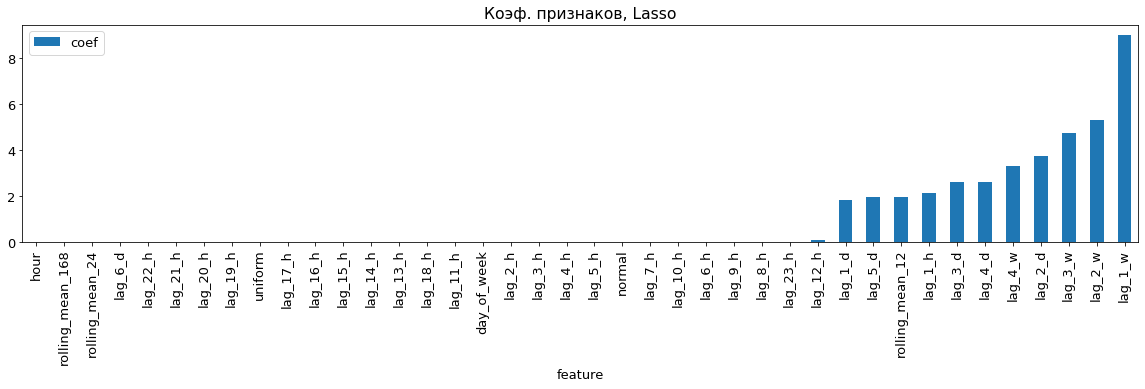

In [25]:
cf_lasso = pd.DataFrame({'coef': pipe_best_lasso.named_steps.model.coef_, 'feature':X_train.columns}).sort_values(by='coef')
cf_lasso.plot(kind='bar', x='feature', y='coef', figsize=(20, 4))
plt.title('Коэф. признаков, Lasso');

In [26]:
# удалим шумгые признаки и признаки, у которых коэфф. меньше, чем у шума
features_lasso = cf_lasso.loc[
    (cf_lasso.coef.abs() > float(cf_lasso.loc[cf_lasso['feature'] == 'uniform', 'coef'].abs())) &
    (cf_lasso.coef.abs() > float(cf_lasso.loc[cf_lasso['feature'] == 'normal', 'coef'].abs())), 'feature'].to_list()
f'Кол-во фичей с коэфф. больше шума: {len(features_lasso)}'

'Кол-во фичей с коэфф. больше шума: 13'

In [27]:
cv_lasso = cv_fit(pipe_best_lasso, features_lasso)

f'Train data CV RMSE lasso: {np.power(cv_lasso, 0.5):.2f}'

'Train data CV RMSE lasso: 22.58'

На графике с коэффициентами признаков наблюдается несколько признаков с малым весом, попробуем убрать эти признаки и проверим метрику на кросс-валидации.

In [28]:
# удалим шумные признаки и признаки с малыми коэффициентами
features_lasso_1 = cf_lasso.loc[cf_lasso.coef.abs() > 1, 'feature'].to_list()
f'Кол-во фичей с коэфф. больше шума: {len(features_lasso_1)}'

'Кол-во фичей с коэфф. больше шума: 11'

In [29]:
cv_lasso_1 = cv_fit(pipe_best_lasso, features_lasso_1)

f'Train data CV RMSE forest: {np.power(cv_lasso_1, 0.5):.2f}'

'Train data CV RMSE forest: 22.58'

Метрика для тренировочных данных с 11 и 13 признаками получилась одинаковой.

#### RandomForestRegressor()

Обучим модель случайного леса.

In [30]:
best_forest = gscv_fit(
    
#     пайнлайн подготовки данных и модель дерева решений
    RandomForestRegressor(n_estimators=10, random_state=RANDOM_STATE, n_jobs=-1),
    
#     гиперпараметры для модели
    {
        'min_samples_split': range(2, 15),
        'min_samples_leaf': range(1, 11)
    }
)

Кросс-валидация и подбор гиперпараметров:
CV-RMSE Train: 23.77


Метрика на кросс-валидации получилась больше, чем у модели Лассо.

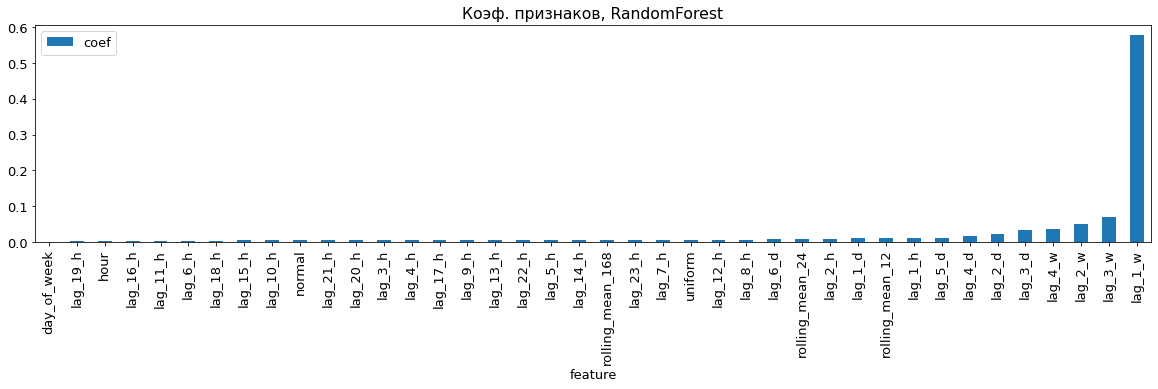

In [31]:
# посмотрим значимость признаков
cf_forest = pd.DataFrame({'coef': best_forest.feature_importances_, 'feature':X_train.columns}).sort_values(by='coef')

cf_forest.plot(kind='bar', x='feature', y='coef', figsize=(20, 4))
plt.title('Коэф. признаков, RandomForest');

В этом случае модель сильно полагается на 1 признак — данные недельной давности.

In [32]:
# удалим признаки, у которых значимость меньше шума
features_forest = cf_forest.loc[
    (cf_forest.coef.abs() > float(cf_forest.loc[cf_forest['feature'] == 'uniform', 'coef'].abs())) &
    (cf_forest.coef.abs() > float(cf_forest.loc[cf_forest['feature'] == 'normal', 'coef'].abs())), 'feature'].to_list()
f'Кол-во фичей с коэфф. больше шума: {len(features_forest)}'

'Кол-во фичей с коэфф. больше шума: 16'

In [33]:
cv_forest = cv_fit(best_forest, features_forest)

f'Train data CV RMSE forest: {np.power(cv_forest, 0.5):.2f}'

'Train data CV RMSE forest: 24.09'

После удаления шумных признаков модель не стала лучше предсказывать значения, метрика чуть ухудшилась.

#### CatBoostRegressor()

In [34]:
def cbr_features_select(n:int) -> list:
    '''
    return n "selected_features_names"  of catboost.select_features()
    '''
    summary = model_cbr.select_features(
        X_train,
        y_train,
        features_for_select=columns,
        eval_set=(X_test, y_test),
        num_features_to_select=n_features,
        steps=2,
        train_final_model=False,
        logging_level="Silent",
        algorithm="RecursiveByLossFunctionChange",
    )
    return summary["selected_features_names"]

In [35]:
model_cbr = catboost.CatBoostRegressor(silent=True, random_seed=RANDOM_STATE)

In [36]:
columns = X_train.columns.drop(['uniform', 'normal'])

У лассо вышло 11/13 фичей со значимостью выше шума, у леса - 16, отберем признаки для catboost и проверим метрики на тренировочных данных.

In [37]:
summary_16 = cbr_features_select(16)

cv_cbr_16 = cv_fit(model_cbr, summary_16)

f'Train data CV RMSE catboost_16: {np.power(cv_cbr_16, 0.5):.2f}'

'Train data CV RMSE catboost_16: 24.78'

In [38]:
summary_13 = cbr_features_select(13)

cv_cbr_13 = cv_fit(model_cbr, summary_13)

f'Train data CV RMSE catboost_13: {np.power(cv_cbr_13, 0.5):.2f}'

'Train data CV RMSE catboost_13: 24.40'

In [39]:
summary_11 = cbr_features_select(11)

cv_cbr_11 = cv_fit(model_cbr, summary_11)

f'Train data CV RMSE catboost_11: {np.power(cv_cbr_11, 0.5):.2f}'

'Train data CV RMSE catboost_11: 25.67'

Градиентный бустинг с тем же количеством признаков справился хуже модели лассо и рандомного леса.

### Лучшая модель и значимость признаков

Наилучшим образом с предсказанием тренирововчных данных справилась модель тассо регуляризации с подбором гиперпараметра и признаков для обучения модели. Посмотрим вклады признаков в предсказания модели.

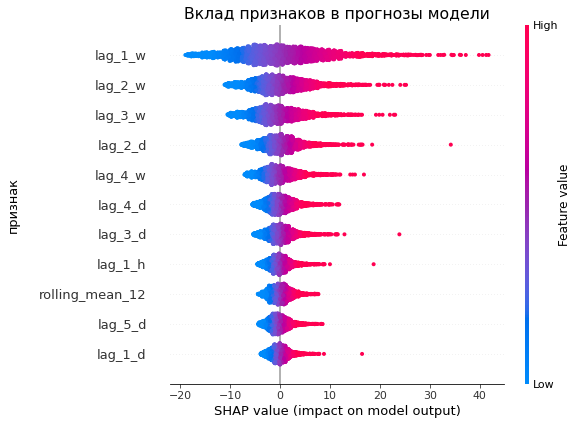

In [40]:
# обучим модель на новых фичах
pipe_best_lasso.fit(X_train[features_lasso_1], y_train)
# сохраним масштабированные данные
scaled_train = pipe_best_lasso.named_steps.scale.transform(X_train[features_lasso_1])

explainer = shap.LinearExplainer(pipe_best_lasso.named_steps.model, scaled_train)
shap_values = explainer.shap_values(scaled_train)

shap.summary_plot(shap_values, scaled_train, features_lasso_1, show=False)
plt.title('Вклад признаков в прогнозы модели')
plt.ylabel('признак\n');

Пять наиболее значимых признаков:
1. данные за прошлую неделю;
2. данные двухнедельной давности;
3. данные трехнедельной давности;
4. данные за позавчера;
5. данные четырехнедельной давности.

Все значимые признаки имеют прямое влияние на предсказания — чем больше кол-во, тем больше заказов такси произойдет.

## Тестирование

Проверим модель на тестовой выборке.

In [41]:
print(f'Test data RMSE lasso: \
{np.power(mean_squared_error(y_test, pipe_best_lasso.predict(X_test[features_lasso_1])), 0.5):.0f}')

Test data RMSE lasso: 35


Получился хороший результат, удовлетворяющий требованиям заказчика.

## Итоговые выводы

1. Был проведен анализ данных.
    * Обнаружена тенденция увеличения количества заказов, причем, тренд растет нелинейно.
    * Обнаружена суточная сезонность и недельная сезонность данных.
    * Анализ шума ряда не показал значительных выбросов к концу графика.
    
    
2. Добавлены новые признаки:
    * ежечасные лаги в первые сутки (до 23-го часа);
    * ежесуточные лаги до первой недели (до 6-го дня);
    * еженедельные лаги до 4-ой недели;
    * скользящее среднее значение за предыдущие 12, 24, 168 часов.


3. Было обучено 3 модели МО с подбором гиперпараметров и входных признаков. Наилучшей моделью оказалась модель с l1-регуляризацией и 11 входными признаками.


4. Лучшая модель показала на тестовых данных метрику RMSE равную 35, что удовлетворяет требованию к качеству модели.